# Lab:  Neural Networks for Music Classification

In addition to the concepts in the [MNIST neural network demo](./demo2_mnist_neural.ipynb), in this lab, you will learn to:
* Load a file from a URL
* Extract simple features from audio samples for machine learning tasks such as speech recognition and classification
* Build a simple neural network for music classification using these features
* Use a callback to store the loss and accuracy history in the training process
* Optimize the learning rate of the neural network

To illustrate the basic concepts, we will look at a relatively simple music classification problem.  Given a sample of music, we want to determine which instrument (e.g. trumpet, violin, piano) is playing.  This dataset was generously supplied by [Prof. Juan Bello](http://steinhardt.nyu.edu/faculty/Juan_Pablo_Bello) at NYU Stenihardt  and his former PhD student Eric Humphrey (now at Spotify).  They have a complete website dedicated to deep learning methods in music informatics:

http://marl.smusic.nyu.edu/wordpress/projects/feature-learning-deep-architectures/deep-learning-python-tutorial/

You can also check out Juan's <a href="http://www.nyu.edu/classes/bello/ACA.html">course</a>.



We first load the standard packages

In [2]:
import numpy as np
import matplotlib
import matplotlib.pyplot as plt

## Audio Feature Extraction with Librosa

The key to audio classification is to extract the correct features. In addition to `pytorch`, we will need the `librosa` package.  The `librosa` package in python has a rich set of methods extracting the features of audio samples commonly used in machine learning tasks such as speech recognition and sound classification.

Installation instructions and complete documentation for the package are given on the [librosa main page](https://librosa.github.io/librosa/).  On most systems, you should be able to simply use:

    pip install -u librosa
    
If you are using Google colab, the packages are already installed.
After you have installed the package, try to import it.

In [3]:
import librosa
import librosa.display
import librosa.feature

In this lab, we will use a set of music samples from the website:

http://theremin.music.uiowa.edu

This website has a great set of samples for audio processing.  Look on the web for how to use the `requests.get` and `file.write` commands to load the file at the URL provided into your working directory.

You can play the audio sample by copying the file to your local machine and playing it on any media player.  If you listen to it you will hear a soprano saxaphone (with vibrato) playing four notes (C, C#, D, Eb).

In [4]:
import requests
fn = "SopSax.Vib.pp.C6Eb6.aiff"
url = "http://theremin.music.uiowa.edu/sound files/MIS/Woodwinds/sopranosaxophone/"+fn

# TODO:  Load the file from url and save it in a file under the name fn
responce = requests.get(url)
with open(fn, 'wb') as f:
  f.write(responce.content)

Next, use `librosa` command `librosa.load` to read the audio file with filename `fn` and get the samples `y` and sample rate `sr`.

In [5]:
# TODO
y, sr = librosa.load(fn)

Extracting features from audio files is an entire subject on its own right.  A commonly used set of features are called the Mel Frequency Cepstral Coefficients (MFCCs).  These are derived from the so-called mel spectrogram which is something like a regular spectrogram, but the power and frequency are represented in log scale, which more naturally aligns with human perceptual processing.  You can run the code below to display the mel spectrogram from the audio sample.

You can easily see the four notes played in the audio track.  You also see the 'harmonics' of each notes, which are other tones at integer multiples of the fundamental frequency of each note.

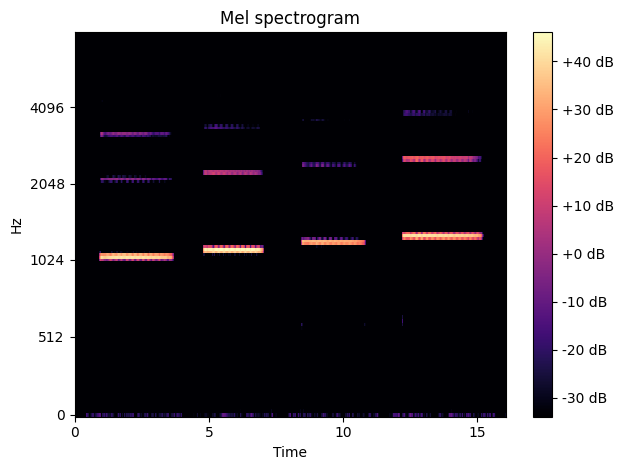

In [6]:
S = librosa.feature.melspectrogram(y=y, sr=sr, n_mels=128, fmax=8000)
librosa.display.specshow(librosa.amplitude_to_db(S),
                         y_axis='mel', fmax=8000, x_axis='time')
plt.colorbar(format='%+2.0f dB')
plt.title('Mel spectrogram')
plt.tight_layout()

## Downloading the Data

Using the MFCC features described above, Eric Humphrey and Juan Bellow have created a complete data set that can used for instrument classification.  Essentially, they collected a number of data files from the website above.  For each audio file, they then segmented the track into notes and then extracted 120 MFCCs for each note.  The goal is to recognize the instrument from the 120 MFCCs.  The process of feature extraction is quite involved.  So, we will just use their processed data provided at:

https://github.com/marl/dl4mir-tutorial/blob/master/README.md

Note the password.  Load the four files into some directory, say  `instrument_dataset`.  Then, load them with the commands.

In [11]:
data_dir = 'instrument_dataset/'
import os
fn = os.path.join(data_dir, 'uiowa_train_data.npy')
Xtr = np.load(fn)
fn = os.path.join(data_dir, 'uiowa_train_labels.npy')
ytr = np.load(fn)
fn = os.path.join(data_dir, 'uiowa_test_data.npy')
Xts = np.load(fn)
fn = os.path.join(data_dir, 'uiowa_test_labels.npy')
yts = np.load(fn)

Looking at the data files:
* What are the number of training and test samples?
* What is the number of features for each sample?
* How many classes (i.e. instruments) are there per class?


In [12]:
# TODO
ntr = Xtr.shape[0]
nts = Xts.shape[0]
nfeatures = Xtr.shape[1]
nclasses = np.unique(ytr).size
print(f'Number of training samples: {ntr}')
print(f'Number of test samples: {nts}')
print(f'Number of features: {nfeatures}')
print(f'Number of classes: {nclasses}')

Number of training samples: 66247
Number of test samples: 14904
Number of features: 120
Number of classes: 10


Before continuing, you must scale the training and test data, `Xtr` and `Xts`.  Compute the mean and std deviation of each feature in `Xtr` and create a new training data set, `Xtr_scale`, by subtracting the mean and dividing by the std deviation.  Also compute a scaled test data set, `Xts_scale` using the mean and std deviation learned from the training data set.

In [13]:
# TODO Scale the training and test matrices
mean = np.mean(Xtr, axis=0)
std = np.std(Xtr, axis=0)
Xtr_scale = (Xtr - mean) / std
Xts_scale = (Xts - mean) / std

## Building a Neural Network Classifier

Following the example in [MNIST neural network demo](./mnist_neural.ipynb).   create a neural network `model` with:
* `nfeatures` inputs
* `nh=256` hidden units
* `sigmoid` activation
* fully connected layer with `nclasses` outputs
* `nn.Softmax` output
* select the input and output shapes correctly


In [46]:
import torch
import torch.nn as nn
import torch.nn.functional as F

# Create the neural network
class Model(nn.Module):
  def __init__(self,nin,nhid,nout):
    super(Model, self).__init__()
    self.fc1 = nn.Linear(nin, nhid)
    self.fc2 = nn.Linear(nhid, nout)
    self.softmax = nn.Softmax(dim=1)


  def forward(self, x):
    x = self.fc1(x)
    x = F.sigmoid(x)
    x = self.fc2(x)
    x = self.softmax(x)
    return x



# TODO:  Create the model
nhid = 256
model = Model(nfeatures,nhid,nclasses)

Now print a summary of the model.  You can use the `torchsummary.summary` method as follows:

In [29]:
from torchsummary import summary

# TODO
summary(model, input_size = (64 ,nfeatures))  # put in the input shape

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Linear-1              [-1, 64, 256]          30,976
            Linear-2               [-1, 64, 10]           2,570
           Softmax-3               [-1, 64, 10]               0
Total params: 33,546
Trainable params: 33,546
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.03
Forward/backward pass size (MB): 0.13
Params size (MB): 0.13
Estimated Total Size (MB): 0.29
----------------------------------------------------------------


Next, create `pytorch` `Dataloader` classes from the numpy arrays.  Note that you must use the scaled data `Xtr_scale` and `Xts_scale`.

In [44]:
from torch.utils.data import DataLoader, TensorDataset

# TODO:  Convert your data to PyTorch tensors.
Xtr_torch = torch.tensor(Xtr_scale,dtype=torch.float32)  # (use dtype=torch.float32)
Xts_torch = torch.tensor(Xts_scale,dtype=torch.float32) ##(use dtype=torch.float32)
ytr_torch = torch.tensor(ytr,dtype=torch.long)  #(use dtype=torch.int32)
yts_torch = torch.tensor(yts,dtype=torch.long)  #(use dtype=torch.int32)

# TODO:  Create a TensorDataset
train_dataset = TensorDataset(Xtr_torch,ytr_torch)
test_dataset = TensorDataset(Xts_torch,yts_torch)

# TODO:  Create a DataLoader
batch_size = 100
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=True)



Create the loss and an optimizer.  For the loss, use `nn.CrossEntropyLoss()`.  For the optimizer, use the `optim.Adam` optimizer with a learning rate of 0.001

In [47]:
import torch.optim as optim

# TODO: Define loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

Fit the model for 20 epochs using the scaled data for both the training and validation.  In each epoch, save the:
*  average training loss
*  training accuracy
*  test accuracy

Your final test accuracy should be >95%.

In [48]:
# Lists to store training and testing accuracy for each epoch
train_accuracy_history = []
test_accuracy_history = []
loss_history = []

# Training loop
epochs = 20

# Training loop
for epoch in range(epochs):
  # TODO:  Train over epoch
  model.train()
  total = 0
  correct = 0
  running_loss = 0
  running_total = 0
  for (data,target) in train_loader:
      optimizer.zero_grad()
      output = model(data)
      loss = criterion(output, target.long())
      loss.backward()
      optimizer.step()

      _, predicted = torch.max(output.data, 1)
      total += target.size(0)
      correct += (predicted == target).sum().item()

      running_loss += loss.item() * data.size(0)
      running_total += target.size(0)

  avg_train_loss = running_loss / running_total
  loss_history.append(avg_train_loss)
  train_accuracy = 100 * correct / total
  train_accuracy_history.append(train_accuracy)

  # --- 修正测试逻辑 ---

  # TODO:  Test over epoch
  model.eval()
  total = 0
  correct = 0
  # 注意：在评估模式下，通常使用 torch.no_grad() 来禁用梯度计算，以节省内存和计算时间。
  with torch.no_grad():
      # 由于您的原始代码只使用最后一个 batch 的结果，我们保持这个逻辑
      for (data,target) in test_loader:
        output = model(data)
        # loss = criterion(output, target.long()) # 计算损失，但此处未存储

        _, predicted = torch.max(output.data, 1)
        total += target.size(0)
        correct += (predicted == target).sum().item()

      # ✅ 修复：将测试准确率追加到正确的列表 test_accuracy_history
      test_accuracy = 100 * correct / total
      test_accuracy_history.append(test_accuracy)


  # TODO:  Print accuracy
  # 此处在列表被填充后，索引 -1 将不再报错
  print(f'Epoch {epoch+1}/{epochs} | Loss: {loss_history[-1]:.4f} | Train Acc: {train_accuracy_history[-1]:.2f}% | Test Acc: {test_accuracy_history[-1]:.2f}%')




Epoch 1/20 | Loss: 1.7512 | Train Acc: 72.93% | Test Acc: 79.41%
Epoch 2/20 | Loss: 1.6441 | Train Acc: 82.13% | Test Acc: 81.66%
Epoch 3/20 | Loss: 1.6076 | Train Acc: 85.64% | Test Acc: 86.18%
Epoch 4/20 | Loss: 1.6028 | Train Acc: 85.95% | Test Acc: 86.25%
Epoch 5/20 | Loss: 1.6008 | Train Acc: 86.06% | Test Acc: 86.27%
Epoch 6/20 | Loss: 1.5597 | Train Acc: 90.44% | Test Acc: 92.37%
Epoch 7/20 | Loss: 1.5379 | Train Acc: 92.48% | Test Acc: 92.44%
Epoch 8/20 | Loss: 1.5363 | Train Acc: 92.54% | Test Acc: 92.60%
Epoch 9/20 | Loss: 1.5354 | Train Acc: 92.57% | Test Acc: 92.52%
Epoch 10/20 | Loss: 1.5347 | Train Acc: 92.62% | Test Acc: 92.56%
Epoch 11/20 | Loss: 1.5341 | Train Acc: 92.65% | Test Acc: 92.51%
Epoch 12/20 | Loss: 1.5335 | Train Acc: 92.68% | Test Acc: 92.35%
Epoch 13/20 | Loss: 1.5332 | Train Acc: 92.71% | Test Acc: 92.55%
Epoch 14/20 | Loss: 1.5329 | Train Acc: 92.70% | Test Acc: 92.47%
Epoch 15/20 | Loss: 1.5325 | Train Acc: 92.73% | Test Acc: 92.47%
Epoch 16/20 | Loss:

Plot the validation accuracy saved in `test_accuracy_history`.  

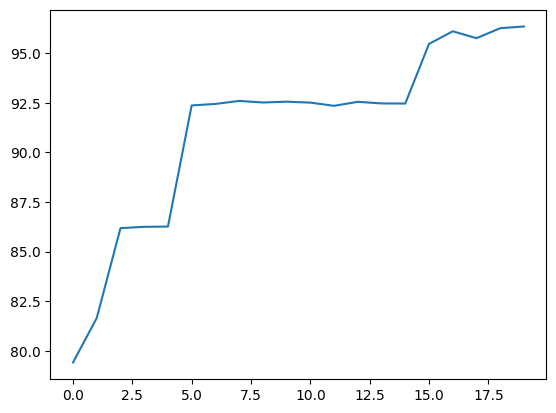

In [49]:
# TODO
plt.plot(test_accuracy_history)

Plot the loss values saved in the `loss_history`.  You should see that the loss is steadily decreasing.  Use the `semilogy` plot.

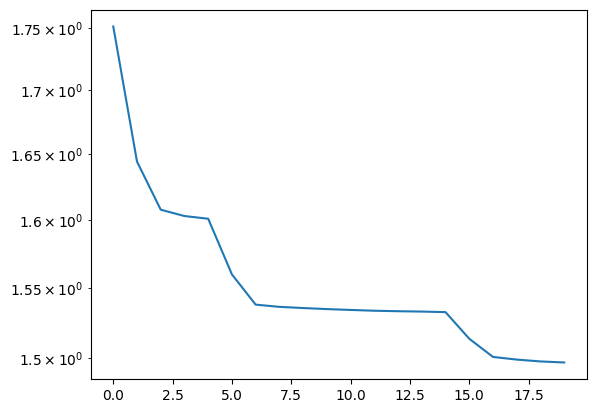

In [50]:
# TODO
plt.semilogy(loss_history)

## Optimizing the Learning Rate

One challenge in training neural networks is the selection of the learning rate.  Rerun the above code, trying four learning rates as shown in the vector `rates`.  For each learning rate:
* construct the network
* select the optimizer.  Use the Adam optimizer with the appropriate learrning rate.
* train the model for 20 epochs
* Save the accuracy and losses

In [64]:
rates = [1e-4, 1e-3, 1e-2]
test_acc_lr = []
loss_hist_lr = []
test_acc_hist_lr = []

# TODO
for lr in rates:

    # TODO:  Create the model
    # model = Model(...)
    model = Model(nfeatures, nhid, nclasses)


    # TODO: Define loss function and optimizer
    #   criterion = ...
    #   optimizer = ...
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=lr)


    # Lists to store training and testing accuracy for each epoch
    train_accuracy_history = []
    test_accuracy_history = []
    loss_history = []

    # Number of epochs
    epochs = 20

    # Training loop
    for epoch in range(epochs):
      # TODO:  Train over epoch
      model.train()
      total = 0
      correct = 0
      running_loss = 0
      running_total = 0
      for (data,target) in train_loader:
          optimizer.zero_grad()
          output = model(data)
          loss = criterion(output, target.long())
          loss.backward()
          optimizer.step()

          _, predicted = torch.max(output.data, 1)
          total += target.size(0)
          correct += (predicted == target).sum().item()

          running_loss += loss.item() * data.size(0)
          running_total += target.size(0)

      avg_train_loss = running_loss / running_total
      loss_history.append(avg_train_loss)
      train_accuracy = 100 * correct / total
      train_accuracy_history.append(train_accuracy)

      # TODO:  Test over epoch
      model.eval()
      total = 0
      correct = 0
      # 注意：在评估模式下，通常使用 torch.no_grad() 来禁用梯度计算，以节省内存和计算时间。
      with torch.no_grad():
          # 由于您的原始代码只使用最后一个 batch 的结果，我们保持这个逻辑
          for (data,target) in test_loader:
            output = model(data)
            # loss = criterion(output, target.long()) # 计算损失，但此处未存储

            _, predicted = torch.max(output.data, 1)
            total += target.size(0)
            correct += (predicted == target).sum().item()

          # ✅ 修复：将测试准确率追加到正确的列表 test_accuracy_history
          test_accuracy = 100 * correct / total
          test_accuracy_history.append(test_accuracy)


      # TODO:  Print accuracy
      print(f'Epoch {epoch+1}/{epochs} | Loss: {loss_history[-1]:.4f} | Train Acc: {train_accuracy_history[-1]:.2f}% | Test Acc: {test_accuracy_history[-1]:.2f}%')

      # TODO:  Save the loss history
    loss_hist_lr.append(loss_history)
    test_acc_hist_lr.append(test_accuracy_history)

Epoch 1/20 | Loss: 1.9827 | Train Acc: 55.68% | Test Acc: 51.01%
Epoch 2/20 | Loss: 1.8352 | Train Acc: 64.78% | Test Acc: 63.71%
Epoch 3/20 | Loss: 1.7579 | Train Acc: 73.32% | Test Acc: 67.67%
Epoch 4/20 | Loss: 1.7093 | Train Acc: 77.48% | Test Acc: 76.04%
Epoch 5/20 | Loss: 1.6784 | Train Acc: 80.18% | Test Acc: 78.61%
Epoch 6/20 | Loss: 1.6660 | Train Acc: 80.92% | Test Acc: 79.03%
Epoch 7/20 | Loss: 1.6438 | Train Acc: 83.25% | Test Acc: 83.56%
Epoch 8/20 | Loss: 1.6268 | Train Acc: 84.56% | Test Acc: 83.42%
Epoch 9/20 | Loss: 1.6218 | Train Acc: 84.81% | Test Acc: 84.42%
Epoch 10/20 | Loss: 1.6183 | Train Acc: 85.00% | Test Acc: 85.01%
Epoch 11/20 | Loss: 1.6156 | Train Acc: 85.20% | Test Acc: 85.49%
Epoch 12/20 | Loss: 1.6135 | Train Acc: 85.33% | Test Acc: 85.70%
Epoch 13/20 | Loss: 1.6117 | Train Acc: 85.44% | Test Acc: 85.49%
Epoch 14/20 | Loss: 1.6103 | Train Acc: 85.53% | Test Acc: 85.62%
Epoch 15/20 | Loss: 1.6090 | Train Acc: 85.62% | Test Acc: 85.70%
Epoch 16/20 | Loss:

Plot the loss funciton vs. the epoch number for all three learning rates on one graph.  You should see that the lower learning rates are more stable, but converge slower.  The higher learning rate either plateaus at a lower validation accuracy or is unstable.

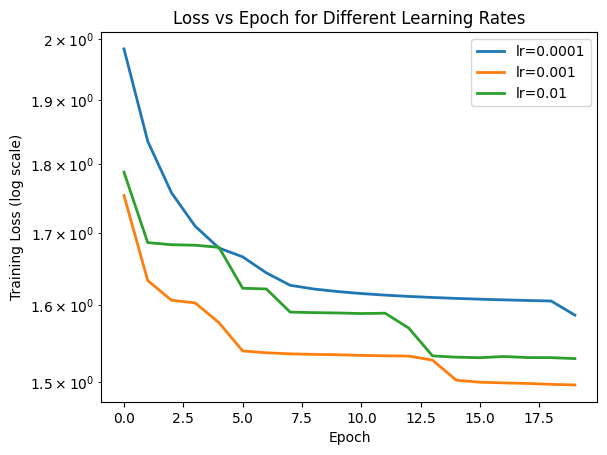

In [68]:

for i, lr in enumerate(rates):
    plt.semilogy(loss_hist_lr[i], label=f'lr={lr}', linewidth=2)

plt.xlabel('Epoch')
plt.ylabel('Training Loss (log scale)')
plt.title('Loss vs Epoch for Different Learning Rates')
plt.legend()
plt.show()
